In [1]:
%load_ext autotime

## Explore Light curve

In [49]:
import os
import numpy as np
import pandas as pd
# from copy import copy

from glob import glob

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.style.use('bmh')
from IPython import display

from astropy.time import Time
from astropy.stats import sigma_clip

from piaa.utils.exoplanets import TransitInfo, get_exoplanet_transit
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils import pipeline

time: 2.81 ms


In [3]:
processed_dir = os.path.join(os.environ['PANDIR'], 'processed')

time: 1.09 ms


In [4]:
# Takes long time - find better way
# psc_files = glob('/var/panoptes/processed/*/PAN012/Hd189733/358d0f/20180822T035809/raw-flux*.csv')

# lc_file = psc_files[np.random.randint(0, len(psc_files))]

# picid = lc_file.split('/')[4]
# picid

time: 2.13 ms


In [5]:
picid = 256364928  # HD 189733
# picid = 11036706
# picid = 11133818  # Ugly PSF
# picid = 388448267 # Ugly PSF
# picid = 435649529

# picid = 417898196
# ticid = 382391899  # Wasp 50
# ticid = 11027938
# ticid = 11133818
# ticid = 452180117

time: 636 µs


In [6]:
# unit_id = 'PAN001'
# field_id = 'Wasp50'
# cam_id = '14d3bd'
# seq_id = '20181215T050712'
# seq_id = '20180913T085704'
unit_id = 'PAN012'
field_id = 'Hd189733'
cam_id = '358d0f'
seq_id = '20180822T035809'

sequence_dir = os.path.join(unit_id, field_id, cam_id, seq_id)
print(sequence_dir)

sequence = '_'.join([unit_id, cam_id, seq_id])
sequence

PAN012/Hd189733/358d0f/20180822T035809


'PAN012_358d0f_20180822T035809'

time: 7.91 ms


In [7]:
psc_dir = os.path.join(processed_dir, str(picid), sequence_dir)
assert os.path.isdir(psc_dir)

# Sort by time so recent is last
!ls -lrst $psc_dir

total 420
16 -rw-r--r-- 1 wtylergee wtylergee 13255 Dec 24 10:17 raw-flux.csv
56 -rw-r--r-- 1 wtylergee wtylergee 56392 Dec 25 00:22 psc.csv
16 -rw-r--r-- 1 wtylergee wtylergee 13367 Dec 25 00:26 similar_sources.csv
12 -rw-r--r-- 1 wtylergee wtylergee 11999 Dec 25 00:55 raw-flux-05-010.csv
12 -rw-r--r-- 1 wtylergee wtylergee 12001 Dec 25 00:59 raw-flux-05-008.csv
12 -rw-r--r-- 1 wtylergee wtylergee 11965 Dec 25 01:03 raw-flux-07-008.csv
12 -rw-r--r-- 1 wtylergee wtylergee 12158 Dec 25 01:06 raw-flux-10-008.csv
12 -rw-r--r-- 1 wtylergee wtylergee 11581 Dec 25 01:07 raw-flux-03-025.csv
16 -rw-r--r-- 1 wtylergee wtylergee 12356 Dec 25 11:45 raw-flux-05-025.csv
16 -rw-r--r-- 1 wtylergee wtylergee 12628 Dec 25 11:49 raw-flux-05-020.csv
16 -rw-r--r-- 1 wtylergee wtylergee 12630 Dec 25 11:58 raw-flux-05-100.csv
16 -rw-r--r-- 1 wtylergee wtylergee 12630 Dec 25 12:18 raw-flux-05-075.csv
16 -rw-r--r-- 1 wtylergee wtylergee 12628 Dec 25 12:25 raw-flux-05-050.csv
16 -rw-r--r-- 1 wtylergee wtylerge

In [8]:
lc_file = os.path.join(psc_dir, 'raw-flux-std3-refs150.csv')

time: 972 µs


In [9]:
lc0 = pd.read_csv(lc_file, index_col=0, parse_dates=True)

time: 18.9 ms


In [10]:
lc0.head()

,color,reference,reference_err,target,target_err
obstime,,,,,
2018-08-22 04:00:29.450,r,14838.0,128.848749,15571.5,131.664346
2018-08-22 04:00:29.450,g,26620.5,168.477001,28699.5,174.537961
2018-08-22 04:00:29.450,b,13347.0,122.926807,15120.0,129.938447
2018-08-22 04:02:19.450,r,16131.0,133.772194,16633.5,135.637384
2018-08-22 04:02:19.450,g,28386.0,173.637554,29769.0,177.575336


time: 19.4 ms


### Show rax flux

Raw flux for green channel for target and reference

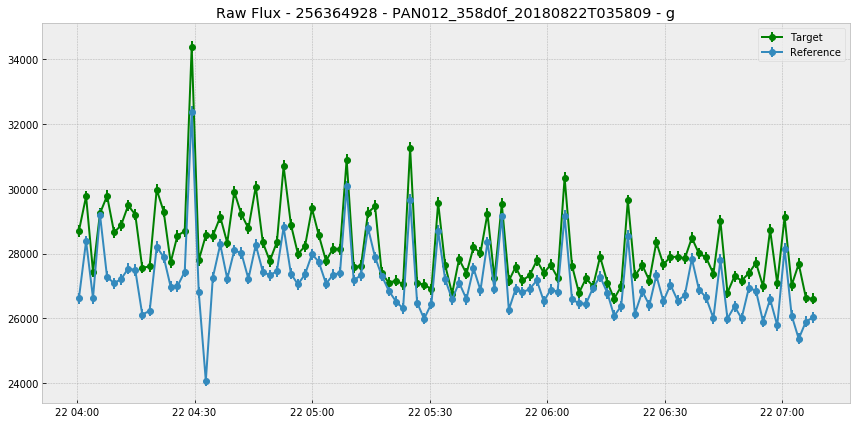

time: 628 ms


In [11]:
color = 'g'
plt.figure(figsize=(12, 6))

y = lc0.loc[lc0.color == color]
x = y.index

plt.errorbar(x, y.target.values, yerr=y.target_err.values, marker='o', color=color, label='Target')
plt.errorbar(x, y.reference.values, yerr=y.reference_err.values, marker='o', label='Reference')
plt.title(f'Raw Flux - {picid} - {sequence} - {color}')
plt.tight_layout()
plt.legend()

### Time binned

_not yet_

In [12]:
# plt.figure(figsize=(12, 6))
# plt.plot(lc0.loc[lc0.color == 'g'].target.values, marker='o', label='Target') #.plot(marker='o')
# plt.plot(lc0.loc[lc0.color == 'g'].reference.values, marker='o', label='Reference') #.plot(marker='o')
# plt.title(f'Raw Flux - {picid} - {sequence}')
# plt.tight_layout()
# plt.legend()

time: 668 µs


### Get normalization values

In [37]:
# Make a copy
lc1 = lc0.copy()

norm_mean = lambda x: np.mean(x)
norm_median = lambda x: np.median(x)

norm_data = lc1[:30].groupby('color')
use_norm = norm_mean

norm_data = lc1.groupby('color')
use_norm = norm_median

for field in ['reference', 'target']:
    color_normer = norm_data[field].apply(use_norm)

    for color, normalizer in color_normer.iteritems():
        print(f"{field} {color} μ={normalizer:.04f}")

        # Get the raw values
        raw_values = lc1.loc[lc1.color == color, (f'{field}')]
        raw_error = lc1.loc[lc1.color == color, (f'{field}_err')]

        lc1.loc[lc1.color == color, (f'{field}')] = (raw_values / normalizer)
        lc1.loc[lc1.color == color, (f'{field}_err')] = (raw_error / normalizer)

reference b μ=13764.0000
reference g μ=26989.5000
reference r μ=15120.0000
target b μ=14592.0000
target g μ=27852.0000
target r μ=15507.0000
time: 71.5 ms


### Plot normalized flux

Show the normalized target and reference along with error bars (which are small enough to not be seen in offset).

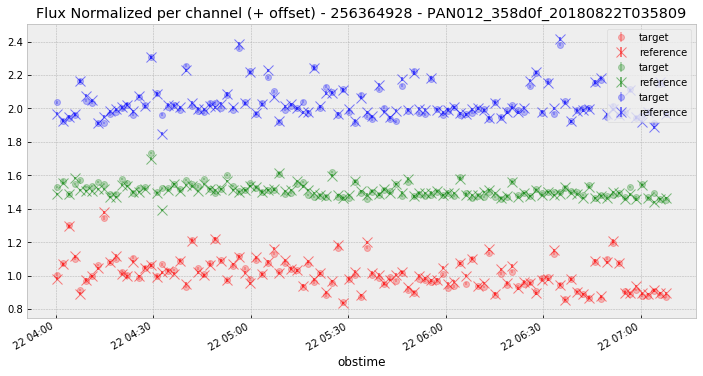

time: 839 ms


In [38]:
plt.figure(figsize=(12, 6))
i = 0
for color in 'rgb':
    color_data = lc1.loc[lc1.color == color]
    (color_data.target + i).plot(marker='o', yerr=color_data.target_err, color=color, ls='', alpha=0.25)
    (color_data.reference + i).plot(marker='x', ms=10, yerr=color_data.reference_err, color=color, ls='', alpha=0.5)
    i += .5

# plt.ylim([.9, 1.1])
plt.title(f'Flux Normalized per channel (+ offset) - {picid} - {sequence}')
plt.legend()

### Model flux

This either comes from modelling an exoplanet transit or is just a straight line.

In [39]:
transit_times = TransitInfo(
    Time('2018-08-22 04:53:00'),
    Time('2018-08-22 05:47:00'),
    Time('2018-08-22 06:41:00')
)

# transit_times = TransitInfo(
#     Time('2018-09-13 09:21:00'),
#     Time('2018-09-13 10:15:00'),
#     Time('2018-09-13 11:09:00')
# )

transit_datetimes = [transit_times.midpoint.datetime, transit_times.ingress.datetime, transit_times.egress.datetime]

base_model_flux = get_exoplanet_transit(x, transit_times=transit_times)

time: 54.8 ms


In [61]:
transit_datetimes = None
base_model_flux = None

time: 815 µs


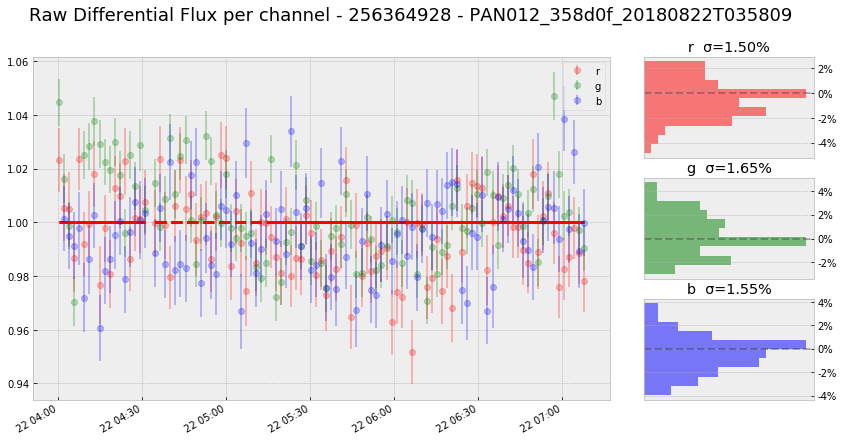

time: 1.4 s


In [69]:
# Setup figure
fig = plt.figure(figsize=(14, 7), facecolor='white')

grid_size = (3, 4)

# Axis for light curve
ax = plt.subplot2grid(grid_size, (0, 0), colspan=3, rowspan=3, fig=fig)

offset = 0  # offset
delta_offset = 0  # offset delta

for i, color in enumerate('rgb'):

    # Get the normalized flux for each channel 
    color_data = lc1.loc[lc1.color == color]

    # Target and error
    t0 = color_data.target
    t0_err = color_data.target_err

    # Reference and error
    r0 = color_data.reference
    r0_err = color_data.reference_err

    # Get the differential flux and error
    diff_flux = t0 / r0
    diff_err = np.sqrt(t0_err**2 + r0_err**2)

    # Sigma clip the differential flux
    f0 = sigma_clip(diff_flux, sigma=3)
    f0_err = np.ma.array(diff_err, mask=f0.mask)
    f0_index = np.ma.array(color_data.index, mask=f0.mask)

    # Model flux
    if base_model_flux is None:
        base_model_flux = np.ones_like(f0)
    else:
        # Mask the sigma clipped frames
        base_model_flux = np.ma.array(base_model_flux, mask=f0.mask)    
#     base_model_flux = np.ones_like(f0)

    ax.plot(f0_index, base_model_flux, ls='--', color='r', lw=3)
    
    # Build dataframe for differntial flux
    flux_df = pd.DataFrame({'flux': f0 + offset, 'flux_err': f0_err}, index=f0_index).dropna()

    # Show the plot
    flux_df.flux.plot(yerr=flux_df.flux_err, 
                      marker='o', ls='', alpha=0.25, color=color,
                      ax=ax,
                      label=f'{color}')

    # Residual axis
    res_ax = plt.subplot2grid(grid_size, (i, 3))
    res_ax.set_xticks([])
    res_ax.yaxis.tick_right()
    res_ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    
    # Residual
    residual = f0 - base_model_flux
    res_ax.hist(residual, orientation='horizontal', color=color, alpha=0.5)
    res_ax.axhline(0, ls='--', color='k', alpha=0.25)
    res_ax.set_title(f'{color}  σ={residual.std():.2%}')

    # Add the offset
    offset += delta_offset
    # Reset for now
    base_model_flux = None

if transit_datetimes is not None:
    midpoint, ingress, egress = transit_datetimes
    ax.axvline(midpoint, ls='-.', c='g', alpha=0.5)
    ax.axvline(ingress, ls='--', c='k', alpha=0.5)
    ax.axvline(egress, ls='--', c='k', alpha=0.5)

fig.suptitle(f'Raw Differential Flux per channel - {picid} - {sequence}', fontsize=18)
ax.legend()

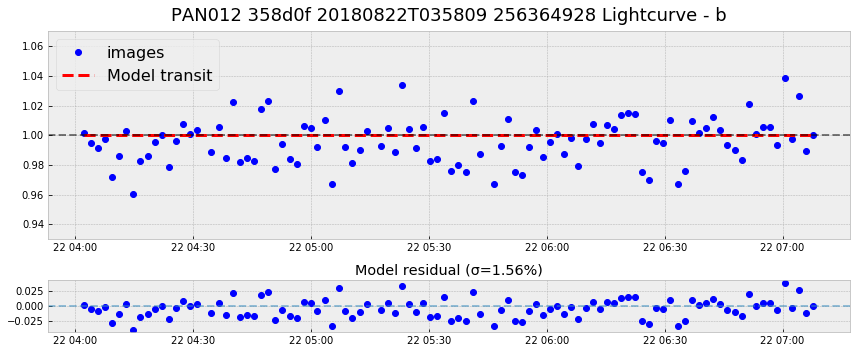

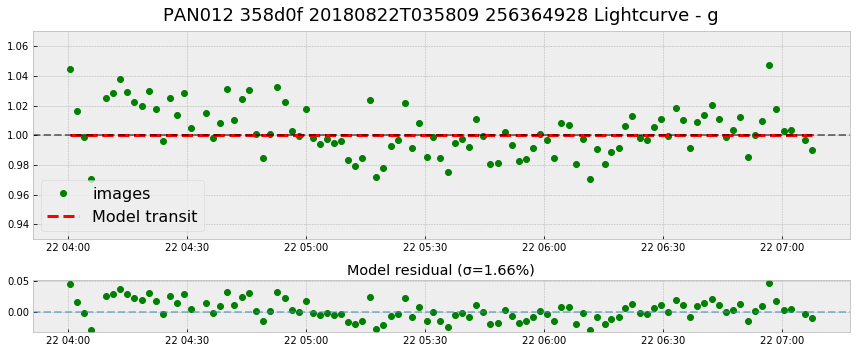

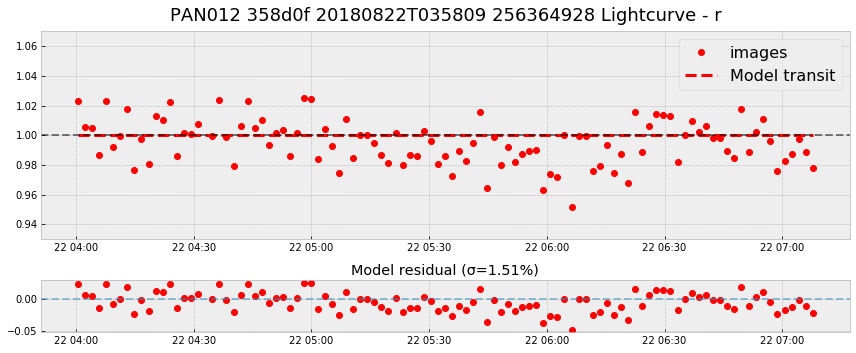

time: 1.57 s


In [255]:
residuals = { 'fn': lc_file }

for color, data in lc1.groupby('color'):
    
    y = pd.Series(sigma_clip(data.target / data.reference), index=lc1.index.unique()).dropna()
    x = y.index
    
    base_model_flux = np.ones_like(y)
#     base_model_flux = get_exoplanet_transit(x, transit_times=transit_times)
    
    lc_fig = plot.plot_lightcurve(x, y, base_model_flux, 
#         transit_info=transit_datetimes,
        title="{} {} Lightcurve - {}".format(sequence.replace('_', ' '), picid, color),
        color=color,
        ylim=[.93, 1.07], 
    )  
    
    # Time bin
#     y2 = y.resample('20T').mean()
#     lc_fig.get_axes()[0].plot(y2.index, y2, color=color, ls='', marker='x', ms=10, mew=5)
#     print((y2 - np.ones_like(y2)).std())
       
    lc_fig.set_size_inches(12, 5)
    
    residual = (y - base_model_flux).std()
    residuals[color] = residual
           
    display.display(lc_fig)

In [218]:
# Mean pre - base

time: 559 µs


In [88]:
# Median - base
residuals

{'fn': '/var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std3-refs075.csv',
 'b': 0.017501034969531287,
 'g': 0.01983907644459603,
 'r': 0.01677604423307225}

time: 3.47 ms


In [81]:
# Mean - base
residuals

{'fn': '/var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std3-refs075.csv',
 'b': 0.01755589135674323,
 'g': 0.019722939681535503,
 'r': 0.01705460474946737}

time: 3.74 ms


In [79]:
# Mean pre - fit
residuals

{'fn': '/var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std3-refs075.csv',
 'b': 0.01975706084626935,
 'g': 0.01640912740902973,
 'r': 0.016915686325044577}

time: 3.09 ms


In [220]:
!echo $residuals >> /var/panoptes/residuals.txt

time: 146 ms


In [221]:
cat /var/panoptes/residuals.txt

{fn: /var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std3-refs020.csv, b: 0.023512244962894214, g: 0.020489415221987908, r: 0.015642022203957006}
{fn: /var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std3-refs020.csv, b: 0.023512244962894214, g: 0.020489415221987908, r: 0.015642022203957006}
{fn: /var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std3-refs010.csv, b: 0.027122060871410572, g: 0.02810659828232737, r: 0.01914459742584575}
{fn: /var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std2-refs020.csv, b: 0.027524255390022474, g: 0.024425393778465348, r: 0.017666022658663273}
{fn: /var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std2-refs075.csv, b: 0.021660756691062794, g: 0.021885278951921966, r: 0.02058300697319687}
{fn: /var/panoptes/processed/256364928/PAN012/Hd189733/358d0f/20180822T035809/raw-flux-std3-refs075.csv

### Exoplanet info

HD 189733 b
```
a........... 8.83602
ecc......... 0.0
fp.......... None
inc......... 85.71
limb_dark... uniform
per......... 2.21857567
rp.......... 0.15468774550850156
t0.......... 0.0
t_secondary. None
u........... []
w........... 90.0
```